## Final - Part A1: Gentrification Measures
### Notebook: Miles Cressy | Group: Race as Vulnerability: The Relationship between Policing and Gentrification

#### Overview
The main goal of our project is to demonstrate not only a methodology in assessing gentrification within the context of the City of Los Angeles but it's relationship with low-level arrest data and on a cursory level, the manner in which they inform each other. This will be done in a series of four notebooks: Part A1, A2, B and C. The methodology in which we approach this project is as follows: an increase in development, which can be evaluated through the issuance of building permits, leads to an increase in rent prices, which ultimately pushes lower income and minority renter-households out of their communities. Literature dictates that gentrifying forces lead to increases in low-level arrests, which we attempt to demonstrate the significance of this relationship.

#### Process
Our project first attempts to capture the code and visualizations associated with the aggregation of various metrics that our team has determined represent significant indicators of gentrifying forces: Building Permit Issuance, Rent Price, and Demographics of Renter-occupied Households. **(Part A1)**. Following the evaluation of these measures of gentrification, our project attempts to define an index for gentrification by combining the aforementioned metrics to serve as an underlay for police data **(Part A2)**.

Once we have established an approach for evaluating gentrification across Los Angeles neighborhoods, we will delve into police data, running a spatial autocorrelation to determine clusters of census block groups that experience high levels of low-level arrests **(Part B)**. 

Following our analysis of low-level arrest data in Los Angeles, we will overlay the clustered census block groups that we've identified over our gentrification index. In doing so, our project aims to highlight key areas that we believe to be experiencing gentrification (or at risk of future gentrifying forces) and the consequent, racialized violence that follows it **(Part C)**.

This notebook captures all code and visualizations related to **Part A1**.
__________________________________________________________________________________________________________________________________________________________________________________________________

Before delving into our various gentrification metrics and subsequent subsections, let's import the packages we will need for data manipulation/cleaning and visualization.

In [2]:
# standard data manipulation
import pandas as pd
import numpy as np
# geospatial data manipulation/visualization
import geopandas as gpd
import plotly as pl
import plotly.express as px
import plotly.graph_objects as go
import libpysal as lp
import contextily as ctx
import json
import seaborn as sns
import plotly.offline as pyo

# advanced graph visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Part A1: Assessing Gentrification

#### A1.1: Development - Builing Permit Issuance

Let's first delve into building permit issuance data for the City of Los Angeles by bringing in data directly from LA City's data portal. We'll do some brief analysis of the data to understand what we are dealing with.

In [3]:
# load in csv
df_permit = pd.read_csv('data/Building_Permits_clean')
# we don't need this column right now - we'll drop for the time being
df_permit = df_permit.drop(columns = '# of Residential Dwelling Units')
df_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584195 entries, 0 to 1584194
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Census Tract        1582874 non-null  float64
 1   Permit Sub-Type     1584195 non-null  object 
 2   Issue Date          1584195 non-null  object 
 3   Latitude/Longitude  1499419 non-null  object 
dtypes: float64(1), object(3)
memory usage: 48.3+ MB


In [4]:
# check size of dataframe
df_permit.shape

(1584195, 4)

This is a very large file, we will need to subset in order to manage it size. Let's start by removing null values so we can trim it down.

In [5]:
# view # of missing values
print(df_permit['Latitude/Longitude'].isna().sum())
print(df_permit['Census Tract'].isna().sum())

84776
1321


In [6]:
# drop missing values and re-check to see if we successfully dropped
df_permit = df_permit[df_permit['Latitude/Longitude'].isna() != True]
df_permit = df_permit[df_permit['Census Tract'].isna() != True]
print(df_permit['Latitude/Longitude'].isna().sum())
print(df_permit['Census Tract'].isna().sum())

0
0


We're almost there but now we need to convert the date column to datetime so we can easily filter that dataframe by year. We will then convert these new dataframes to geodataframes so that we can join this data with the LA neighborhood boundaries.

In [7]:
# convert column to datetime, then subset dataframe into two separate based on year the permit was issued (2021 vs 2017)
df_permit['Issue Date'] = pd.to_datetime(df_permit['Issue Date'])
df_permit = df_permit[(df_permit['Issue Date'] > '2017-01-01') & (df_permit['Issue Date'] < '2022-01-01')]
df_permit.shape

(775166, 4)

In [8]:
# we need to parse out the lat/long values into a format that geopandas can join on, we'll split the column 'Latitude/Longitude' into 'lat' and 'long' and convert to numeric
# split column, then adding new columns with split results
df_permit[['lat', 'long']] = df_permit['Latitude/Longitude'].str.split(', ', expand=True)
# remove unnessary characters
df_permit["lat"]=df_permit["lat"].str.replace('(','')
df_permit["long"]=df_permit["long"].str.replace(')','')
# convert string to numeric
df_permit['lat'] = pd.to_numeric(df_permit['lat'])
df_permit['long'] = pd.to_numeric(df_permit['long'])
# drop unused column
df_permit = df_permit.drop(columns = ['Latitude/Longitude'])
df_permit.head()

Census Tract         Permit Sub-Type Issue Date       lat       long
0       2364.00  1 or 2 Family Dwelling 2021-10-06  34.00870 -118.35113
1       1920.02               Apartment 2021-10-01  34.08411 -118.35721
2       1347.20              Commercial 2021-10-08  34.20129 -118.56321
3       1439.01              Commercial 2021-02-12  34.14508 -118.41248
4       1872.00  1 or 2 Family Dwelling 2021-06-16  34.10709 -118.25077

In [9]:
# create a new dataframe that subsets the original data to only contain 2021 observations
df_permit_2021 = df_permit[(df_permit['Issue Date'] > '2021-01-01') & (df_permit['Issue Date'] < '2022-01-01')]
# create a new dataframe that subsets the original data to only contain 2021 observations
df_permit_2017 = df_permit[(df_permit['Issue Date'] > '2017-01-01') & (df_permit['Issue Date'] < '2018-01-01')]

In [10]:
# check size of the dataframes
print(df_permit_2021.shape)
print(df_permit_2017.shape)

(148470, 5)
(160697, 5)


Considering we will want to visualize this data spatially, let's convert it into a geodataframe.

In [11]:
# convert dataframes into geodataframes
gdf_permit_2021 = gpd.GeoDataFrame(df_permit_2021,
                         crs='epsg:4326',
                       geometry=gpd.points_from_xy(df_permit_2021['long'], df_permit_2021['lat']))

gdf_permit_2017 = gpd.GeoDataFrame(df_permit_2017,
                         crs='epsg:4326',
                       geometry=gpd.points_from_xy(df_permit_2017['long'], df_permit_2017['lat']))

Since one location can have a multitude of permits issued, we will drop duplicates based on lat/long so that we are not counting the same development more than once. Once we've done so, we can then spatially join with the neighborhood boundaries.

In [12]:
# drop duplicates from both dataframes and evaluate how many rows were dropped as a result
print('# of 2021 sites before dropping duplicates:', gdf_permit_2021.shape[0])
gdf_permit_2021 = gdf_permit_2021.drop_duplicates(subset='geometry')
print('# of 2021 sites after dropping duplicates:', gdf_permit_2021.shape[0])

print('# of 2017 sites before dropping duplicates:', gdf_permit_2017.shape[0])
gdf_permit_2017 = gdf_permit_2017.drop_duplicates(subset='geometry')
print('# of 2017 sites after dropping duplicates:', gdf_permit_2017.shape[0])

# of 2021 sites before dropping duplicates: 148470
# of 2021 sites after dropping duplicates: 72814
# of 2017 sites before dropping duplicates: 160697
# of 2017 sites after dropping duplicates: 73266


Quick pause before we spatially join with neighborhood data - let's see what this look like as raw point data.

In [ ]:
# cleared output to reduce size
# plot using plotly.express with color indicating permit type
fig = px.scatter_mapbox(gdf_permit_2021,
                        lat=gdf_permit_2021.geometry.y,
                        lon=gdf_permit_2021.geometry.x,
                        mapbox_style="carto-positron",
                        color = 'Permit Sub-Type',
                        opacity = .6,
                        zoom=9.15, 
                        center = {"lat": 34.02, "lon": -118.38411},)

# options on the layout
fig.update_layout(
    width = 1000,
    height = 800,
    title = "Interactive Map of Permit Issuances for 2021 by Permit Type",
    title_x=0.5 # aligns title to center
) 

fig.show()

It's interesting to note that there is a high concentration of commercial and apartment permits being issued in the downtown area. This is expected but the contrast is very noticeable in this plot. Additionally, it is interesting that we can essentially visualize the street network of the city based on the difference in location for types of permits being issued. Apartment and commerical permits are located adjacent to major thoroughfares while residential permits are located in blocks between theses major streets/boulevards. 

Although it is helpful to understand where these permits are being issued via point data, we want to understand the change over time in development within the broader context of Los Angeles neighborhoods. We will do this by bringing in boundaries of LA neighborhoods and spatially join the 2017 and 2021 permit dataframes. Once we've done this, we can create a new column that assigns each neighborhood a value that evaluates the degree to which permit issuance counts have changed over time.

In [14]:
# import LA neighborhoods from ArcGIS
nbh = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

# spatial join on dataframes created above and neighborhood geodataframe
neighborhoods_permits_2021 = gpd.sjoin(nbh, gdf_permit_2021)
neighborhoods_permits_2017 = gpd.sjoin(nbh, gdf_permit_2017)

In [15]:
# drop unused columns
neighborhoods_permits_2021 = neighborhoods_permits_2021.drop(columns = ['index_right', 'Issue Date','lat','long','Census Tract'])
neighborhoods_permits_2017 = neighborhoods_permits_2017.drop(columns = ['index_right', 'Issue Date','lat','long','Census Tract'])

In [17]:
# inspect dataframe
neighborhoods_permits_2021

OBJECTID             name  \
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
..        ...              ...   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   

                                              geometry         Permit Sub-Type  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...  1 or 2 Family Dwelling  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...  1 or 2 Family Dwelling  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...               Apartment  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...               Apartment  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...  1 or 2 Family Dwelling  
..                                                 ...                     ...  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...  1 or 2 Family Dwelling  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...  1 or 2 Family Dwelling  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...  1 or 2 Family Dwelling  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...  1 or 2 Family Dwelling  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...  1 or 2 Family Dwelling  

[72789 rows x 4 columns]

Let's take a quick look at the values for each neighborhood by permit type as this represents how we want to structure and organize our dataframes.

In [18]:
# view breakdown by name, by permit type and their counts
neighborhoods_permits_2021.groupby(['name','Permit Sub-Type']).size()

name             Permit Sub-Type       
Adams-Normandie  1 or 2 Family Dwelling    121
                 Apartment                  56
                 Commercial                 17
                 Special Equipment           1
Arleta           1 or 2 Family Dwelling    566
                                          ... 
Woodland Hills   Apartment                 124
                 Commercial                143
                 Onsite                     22
                 Public Safety Only          2
                 Special Equipment           4
Length: 578, dtype: int64

In [19]:
# view breakdown by name, by permit type and their counts
neighborhoods_permits_2017.groupby(['name','Permit Sub-Type']).size()

name             Permit Sub-Type       
Adams-Normandie  1 or 2 Family Dwelling    101
                 Apartment                  54
                 Commercial                 26
                 Offsite                     1
                 Onsite                      1
                                          ... 
Woodland Hills   Apartment                 108
                 Commercial                209
                 Onsite                     34
                 Public Safety Only          2
                 Special Equipment           2
Length: 537, dtype: int64

We now have two dataframes with each row indicating a development, by neighborhood, by type. We now want to reduce the number of rows to the number of neighborhoods in LA City, with a count representing the total number of permits for each category represented by a column. We will do this by getting dummies for each permit type, summing their values for each neighborhood and then dropping duplicates.

In [20]:
# make dataframes wider by getting dummies for permit type
neighborhoods_permits_2021 = pd.get_dummies(neighborhoods_permits_2021, columns=['Permit Sub-Type'])
neighborhoods_permits_2017 = pd.get_dummies(neighborhoods_permits_2017, columns=['Permit Sub-Type'])
# the last four permit types are a small fraction of the total permit counts, to simplify our analysis, we will drop these columns.
neighborhoods_permits_2021 = neighborhoods_permits_2021.drop(columns = ['Permit Sub-Type_Offsite', 'Permit Sub-Type_Onsite', 'Permit Sub-Type_Public Safety Only', 'Permit Sub-Type_Special Equipment'])
neighborhoods_permits_2017 = neighborhoods_permits_2017.drop(columns = ['Permit Sub-Type_Offsite', 'Permit Sub-Type_Onsite', 'Permit Sub-Type_Public Safety Only', 'Permit Sub-Type_Special Equipment'])
# rename columns
neighborhoods_permits_2021 = neighborhoods_permits_2021.rename(columns={"Permit Sub-Type_1 or 2 Family Dwelling": "sfh","Permit Sub-Type_Apartment":"apt","Permit Sub-Type_Commercial":"com"})
neighborhoods_permits_2017 = neighborhoods_permits_2017.rename(columns={"Permit Sub-Type_1 or 2 Family Dwelling": "sfh","Permit Sub-Type_Apartment":"apt","Permit Sub-Type_Commercial":"com"})

In [21]:
# check dataframe to confirm
neighborhoods_permits_2021

OBJECTID             name  \
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
..        ...              ...   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   

                                              geometry  sfh  apt  com  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...    1    0    0  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...    1    0    0  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...    0    1    0  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...    0    1    0  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...    1    0    0  
..                                                 ...  ...  ...  ...  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...    1    0    0  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...    1    0    0  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...    1    0    0  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...    1    0    0  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...    1    0    0  

[72789 rows x 6 columns]

In [22]:
# sum total count of permits by neighborhood and then drop duplicates
# 2021 dataframe
neighborhoods_permits_2021['sfh'] = neighborhoods_permits_2021.groupby("name", sort=False)["sfh"].transform('sum')
neighborhoods_permits_2021['apt'] = neighborhoods_permits_2021.groupby("name", sort=False)["apt"].transform('sum')
neighborhoods_permits_2021['com'] = neighborhoods_permits_2021.groupby("name", sort=False)["com"].transform('sum')
neighborhoods_permits_2021 = neighborhoods_permits_2021.drop_duplicates()

# 2017 dataframe
neighborhoods_permits_2017['sfh'] = neighborhoods_permits_2017.groupby("name", sort=False)["sfh"].transform('sum')
neighborhoods_permits_2017['apt'] = neighborhoods_permits_2017.groupby("name", sort=False)["apt"].transform('sum')
neighborhoods_permits_2017['com'] = neighborhoods_permits_2017.groupby("name", sort=False)["com"].transform('sum')
neighborhoods_permits_2017 = neighborhoods_permits_2017.drop_duplicates()

In [23]:
# create total permit column for each year
# 2021 dataframe
neighborhoods_permits_2021['total'] = neighborhoods_permits_2021['sfh'] + neighborhoods_permits_2021['apt'] + neighborhoods_permits_2021['com']
# 2017 dataframe
neighborhoods_permits_2017['total'] = neighborhoods_permits_2017['sfh'] + neighborhoods_permits_2017['apt'] + neighborhoods_permits_2017['com']

In [24]:
# check results
neighborhoods_permits_2021

OBJECTID                    name  \
0           1         Adams-Normandie   
1           2                  Arleta   
2           3       Arlington Heights   
3           4         Atwater Village   
4           5  Baldwin Hills/Crenshaw   
..        ...                     ...   
109       110              Wilmington   
110       111          Windsor Square   
111       112                Winnetka   
112       113          Woodland Hills   
113       114             Lake Balboa   

                                              geometry   sfh  apt  com  total  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   121   56   17    194  
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...   566    5   23    594  
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...   132   72   31    235  
3    MULTIPOLYGON (((-118.27886 34.15321, -118.2788...   293   32   47    372  
4    POLYGON ((-118.36102 34.02532, -118.36026 34.0...   398  203   31    632  
..                                                 ...   ...  ...  ...    ...  
109  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...   292   32  115    439  
110  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   153   14   13    180  
111  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   996   57   49   1102  
112  POLYGON ((-118.57240 34.18668, -118.57161 34.1...  2025  124  143   2292  
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   789   34   26    849  

[114 rows x 7 columns]

We now have two dataframes with permit counts for two separate years that coincide with the LA neighborhoods that we want to analyze. With this completed, we will merge the dataframes and generate a new column with the % change in permit count to derive a proxy value that roughly indicates the growth in development across LA cities. 

In [25]:
# merge dataframes so that we have one dataframe containing one row for each neighborhood and permit issuance counts for each year and permit type
neighborhoods_permits_combined = neighborhoods_permits_2021.merge(neighborhoods_permits_2017,suffixes=('_2021', '_2017'),on="name")
# subset dataframe to only contain useful columns
neighborhoods_permits_combined = neighborhoods_permits_combined[['name','geometry_2021','sfh_2021','apt_2021','com_2021','total_2021','sfh_2017','apt_2017','com_2017','total_2017']]
# rename geometry column
neighborhoods_permits_combined = neighborhoods_permits_combined.rename(columns={'geometry_2021':'geometry'})
# generate new column to account for permit change over time
neighborhoods_permits_combined['Permit Number Percent Change'] = (neighborhoods_permits_combined.total_2021/neighborhoods_permits_combined.total_2017)*100
# sort by name
neighborhoods_permits_combined = neighborhoods_permits_combined.sort_values('name')
# view dataframe
neighborhoods_permits_combined

name  \
0           Adams-Normandie   
1                    Arleta   
2         Arlington Heights   
3           Atwater Village   
4    Baldwin Hills/Crenshaw   
..                      ...   
108                Westwood   
109              Wilmington   
110          Windsor Square   
111                Winnetka   
112          Woodland Hills   

                                              geometry  sfh_2021  apt_2021  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...       121        56   
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...       566         5   
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...       132        72   
3    MULTIPOLYGON (((-118.27886 34.15321, -118.2788...       293        32   
4    POLYGON ((-118.36102 34.02532, -118.36026 34.0...       398       203   
..                                                 ...       ...       ...   
108  POLYGON ((-118.42946 34.07925, -118.42938 34.0...       354       236   
109  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...       292        32   
110  POLYGON ((-118.31404 34.06254, -118.31420 34.0...       153        14   
111  POLYGON ((-118.56232 34.23199, -118.56232 34.2...       996        57   
112  POLYGON ((-118.57240 34.18668, -118.57161 34.1...      2025       124   

     com_2021  total_2021  sfh_2017  apt_2017  com_2017  total_2017  \
0          17         194       101        54        26         181   
1          23         594       602         8        20         630   
2          31         235       154        99        45         298   
3          47         372       284        14        75         373   
4          31         632       324       190        58         572   
..        ...         ...       ...       ...       ...         ...   
108        90         680       402       245       102         749   
109       115         439       299        30       214         543   
110        13         180       159         9        18         186   
111        49        1102       795        42        82         919   
112       143        2292      1697       108       209        2014   

     Permit Number Percent Change  
0                      107.182320  
1                       94.285714  
2                       78.859060  
3                       99.731903  
4                      110.489510  
..                            ...  
108                     90.787717  
109                     80.847145  
110                     96.774194  
111                    119.912949  
112                    113.803376  

[114 rows x 11 columns]

Before we plot the dataframe, we want to remove the neighborhoods that have low permit counts as they are neighborhoods with an insignificant number of people (i.e. Griffith Park, Hansen Dam, etc.)

In [26]:
# subset dataframe with total permits less than 50.
neighborhoods_permits_combined_plot = neighborhoods_permits_combined[neighborhoods_permits_combined['total_2017'] > 50].sort_values('Permit Number Percent Change', ascending = False)

Now let's take a look at how the top 20 neighborhoods that rank highest in their percent change for building permit issuance through a bar chart.

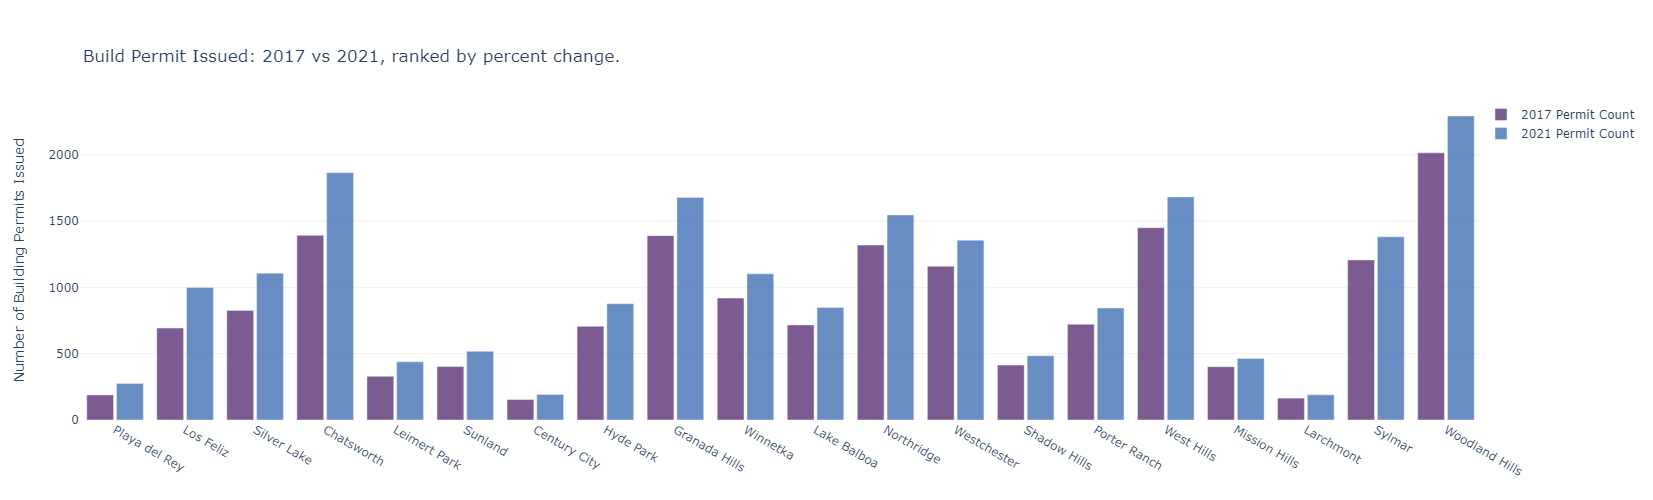

In [27]:
# let's plot our findings from above via a bar graph with neighborhoods on the x-axis, with the left bar indicating 2017 building permit numbers and the right bar indicating 2021 building permit numbers
fig = go.Figure()

fig.add_trace(go.Bar(x=neighborhoods_permits_combined_plot.head(20)['name'],
                y=neighborhoods_permits_combined_plot.head(20)['total_2017'],
                name='2017 Permit Count',
                marker_color='#5c3379',
                     opacity = .8
                ))
fig.add_trace(go.Bar(x=neighborhoods_permits_combined_plot.head(20)['name'],
                y=neighborhoods_permits_combined_plot.head(20)['total_2021'],
                name='2021 Permit Count',
                marker_color='#4371b5',
                     opacity = .8
                ))

fig.update_layout(
    title='Build Permit Issued: 2017 vs 2021, ranked by percent change.',
    title_y = .9,
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Number of Building Permits Issued',
        titlefont_size=14,
        tickfont_size=12,
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 ,# gap between bars of the same location coordinate.
    
    width=1500,
    height=500
)

fig.update_yaxes(showgrid=True, gridwidth=.5, gridcolor='#e0e0e0')
fig.show()

Now that we have visualized the absolute values of permit issuances for the two years, let's take a look at how these values have changed overtime via a choropleth map with the color indicating the percent change between the two years. We'll create a function to do this so we can streamline our other metrics that will also utilize this visualization technique.

In [28]:
# set geometry for proper plotting
neighborhoods_permits_combined_plot = neighborhoods_permits_combined_plot.set_geometry('geometry')

In [29]:
# create function that takes inputs for data, value to measure, a descriptive title, latitude, longitude and bounds for the measured value.
# output is an interactive choropleth map
def chor_map(data=neighborhoods_permits_combined_plot,
             color = 'Permit Number Percent Change', 
             title = 'Interactive Map', 
             lat = 34.02, 
             lon = -118.38, 
             range_color=(), 
             cmap = "dense", 
             color_discrete = px.colors.qualitative.G10,
             color_discrete_map = {},
             title_x = .1):
    # create chloropleth map that evaluates the differential seen between the two bars above (expanded for whole dataset rather than just black neighborhoods)
    fig = px.choropleth_mapbox(data, geojson=data['geometry'], locations=data.index, color=color,
                               mapbox_style="carto-positron",
                               range_color=range_color,
                               zoom=9.15, 
                               center = {"lat": lat, "lon": lon},
                               opacity=0.6,
                               hover_name = 'name',
                               color_continuous_scale = cmap,
                               color_discrete_sequence=color_discrete,
                               color_discrete_map=color_discrete_map)

    # options on the layout
    fig.update_layout(
        width = 1000,
        height = 800,
        title = title,
        title_y=.96,
        title_x=title_x,
    ) 

    fig.show()

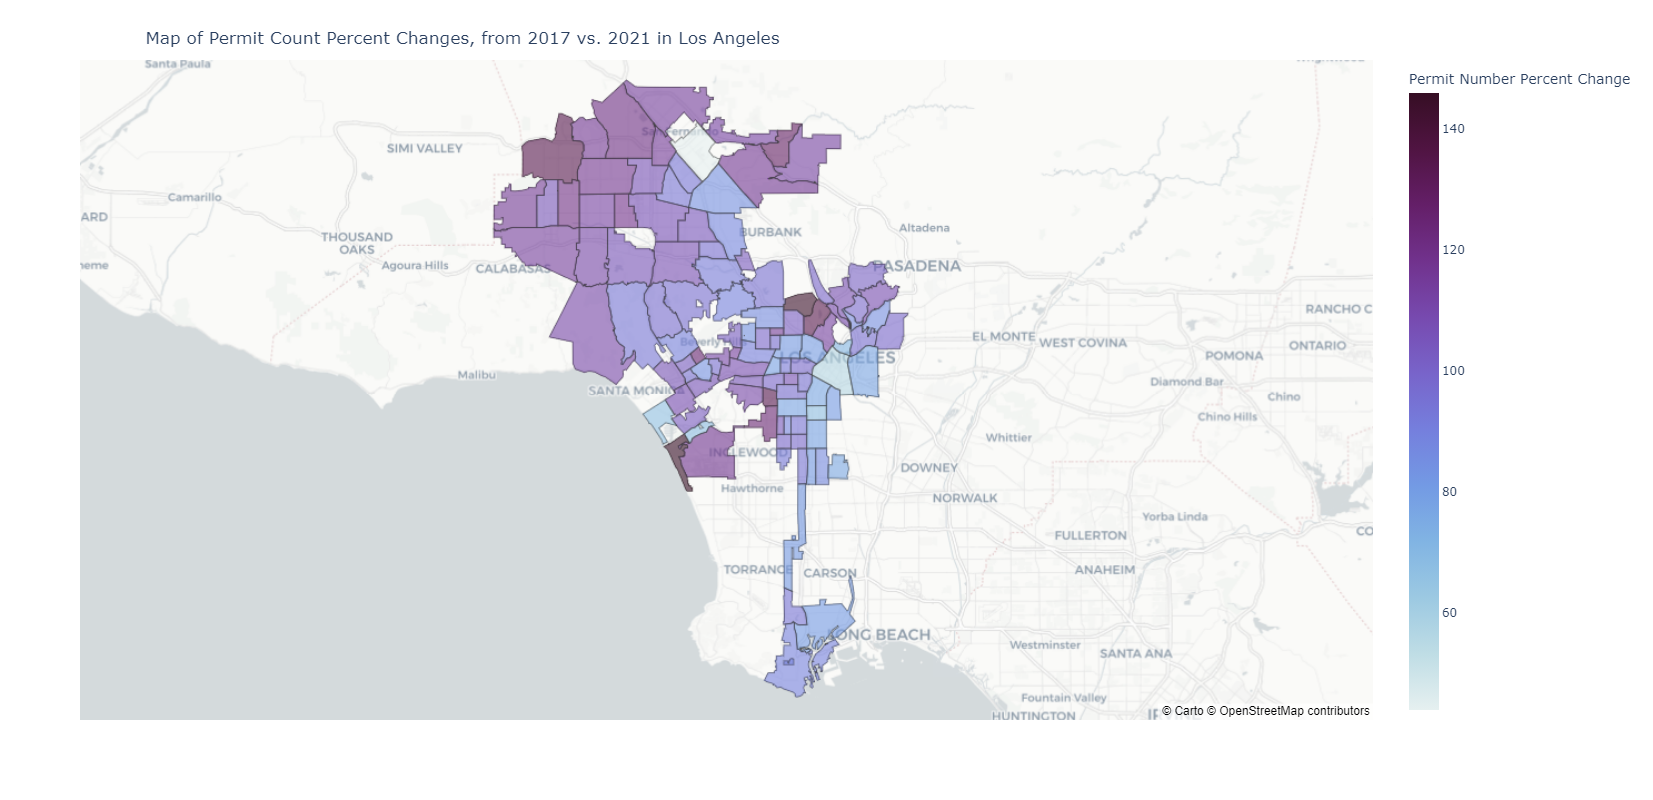

In [30]:
# create chloropleth map that evaluates the differential seen between the two bars above (expanded for whole dataset rather than just black neighborhoods)
chor_map(title="Map of Permit Count Percent Changes, from 2017 vs. 2021 in Los Angeles", color = 'Permit Number Percent Change', title_x = .088)

Remarks:
- Although there is not too much to glean from this quite yet as it has not been integrated with our other metrics, we've successfully developed a better understanding of development patterns by neighborhood from the 2017 to 2021.
- It appears that the Valley has higher rates of change for permits issued as compared to neighborhoods on the other side of the hills.
- Downtown has demonstrated a dramatic decrease in its total permits over this time period.
________________________________________________________________________________________________________________________________________________________________________________________________________________

#### A1.2: Rent Price Shifts

The next variable we will assess is the change in rent price values from 2017 to 2021 (5 year averages). We will essentially mirror the process conducted in the previous exercise by merging census tract level data with our neighborhood boundaries. This will help us develop a better understanding of if and to what degree minority neighborhoods are in the process of or at risk of being priced out of their community. 

In [31]:
# bring in 2017 rent data
df_rent_2017 = pd.read_csv('data/rent_2017.csv', dtype = {'FIPS':str})
# bring in 2021 rent data
df_rent_2021 = pd.read_csv('data/rent_2021.csv', dtype = {'FIPS':str})

# add leading zeroes
df_rent_2017['FIPS'] = df_rent_2017['FIPS'].str.zfill(11)
df_rent_2021['FIPS'] = df_rent_2017['FIPS'].str.zfill(11)

Merging, checking for null values, dropping if need be, and taking a glimpse at the data.

In [32]:
# merge data 
df_rent=df_rent_2021.merge(df_rent_2017,on="FIPS")
# check for na values
df_rent.isna().sum()

FIPS          0
rent_2021    26
rent_2017    48
dtype: int64

In [33]:
# drop na values and re-check
df_rent = df_rent.dropna()
df_rent.isna().sum()

FIPS         0
rent_2021    0
rent_2017    0
dtype: int64

In [34]:
# assess rent statistics
df_rent.describe()

rent_2021    rent_2017
count  2273.000000  2273.000000
mean   1793.182578  1478.293005
std     569.445769   498.306007
min     263.000000   306.000000
25%    1392.000000  1138.000000
50%    1664.000000  1334.000000
75%    2052.000000  1695.000000
max    3501.000000  3501.000000

We have our rent dataframe correctly organized by census tract but we will want to merge it with our dataframe that contains spatial information so that we can ultimately locate the census tracts within our neighborhoods.

In [36]:
# bring in census tract spatial information
tracts=gpd.read_file('data/Census_Tracts_2020.geojson')
# subset for only relevant information
tracts = tracts[['CT20','geometry']]
# create new column using CT20 column that allows us to merge on FIPS
tracts['FIPS'] ='06' + '037' + tracts['CT20']
# merge dataframes together
spatial_rent=tracts.merge(df_rent, on='FIPS')
# check if successful
spatial_rent

CT20                                           geometry         FIPS  \
0     101110  POLYGON ((-118.28491 34.25948, -118.28492 34.2...  06037101110   
1     101122  POLYGON ((-118.29015 34.27417, -118.29015 34.2...  06037101122   
2     101220  POLYGON ((-118.28100 34.25592, -118.28198 34.2...  06037101220   
3     101300  POLYGON ((-118.26530 34.25735, -118.26530 34.2...  06037101300   
4     101400  POLYGON ((-118.29657 34.25356, -118.29694 34.2...  06037101400   
...      ...                                                ...          ...   
1958  980008  POLYGON ((-118.49909 34.22160, -118.49903 34.2...  06037980008   
1959  980015  POLYGON ((-118.28104 33.78180, -118.28105 33.7...  06037980015   
1960  980019  POLYGON ((-118.53452 34.13038, -118.53451 34.1...  06037980019   
1961  980024  POLYGON ((-118.47042 34.18044, -118.47293 34.1...  06037980024   
1962  980031  POLYGON ((-118.26315 33.76749, -118.26339 33.7...  06037980031   

      rent_2021  rent_2017  
0        1689.0     1566.0  
1        2529.0     2170.0  
2        1484.0     1148.0  
3        1525.0     2353.0  
4        2393.0     1225.0  
...         ...        ...  
1958     1319.0     1156.0  
1959      790.0      950.0  
1960     1967.0     3250.0  
1961     1773.0     2269.0  
1962     1780.0     1607.0  

[1963 rows x 5 columns]

Prepare our new dataframe which contains geospatial census tract information by creating a centroid for the census boundaries. Then run a spatial join and check if successful.

In [37]:
# prepare demographic data for spatial join with neighborhoods
# first adjust census data to point data 
spatial_rent = spatial_rent.to_crs(4326)
spatial_rent['Centroid']=spatial_rent.to_crs('+proj=cea').centroid.to_crs(spatial_rent.crs)
spatial_rent_1 = spatial_rent.to_crs(4326)
spatial_rent_1 = spatial_rent.drop(columns=['CT20','geometry'])
spatial_rent_1.rename(columns={'Centroid': 'geometry'}, inplace=True)
spatial_rent_1

FIPS  rent_2021  rent_2017                     geometry
0     06037101110     1689.0     1566.0  POINT (-118.29300 34.25948)
1     06037101122     2529.0     2170.0  POINT (-118.29016 34.26773)
2     06037101220     1484.0     1148.0  POINT (-118.28164 34.25161)
3     06037101300     1525.0     2353.0  POINT (-118.27101 34.24878)
4     06037101400     2393.0     1225.0  POINT (-118.29417 34.24286)
...           ...        ...        ...                          ...
1958  06037980008     1319.0     1156.0  POINT (-118.49069 34.21064)
1959  06037980015      790.0      950.0  POINT (-118.29320 33.77653)
1960  06037980019     1967.0     3250.0  POINT (-118.54819 34.09130)
1961  06037980024     1773.0     2269.0  POINT (-118.48863 34.17668)
1962  06037980031     1780.0     1607.0  POINT (-118.26284 33.73560)

[1963 rows x 4 columns]

In [38]:
# spatial join
nbh_rent = nbh.sjoin(spatial_rent_1, how="left")
nbh_rent = nbh_rent.drop(columns = ['OBJECTID','index_right','FIPS'])
nbh_rent

name                                           geometry  \
0    Adams-Normandie  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
0    Adams-Normandie  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
0    Adams-Normandie  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
0    Adams-Normandie  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
0    Adams-Normandie  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   
..               ...                                                ...   
113      Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   
113      Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   
113      Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   
113      Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   
113      Lake Balboa  POLYGON ((-118.50116 34.22114, -118.50116 34.2...   

     rent_2021  rent_2017  
0       1307.0      937.0  
0       2589.0     1250.0  
0       1303.0     1130.0  
0       2284.0      961.0  
0       1397.0      946.0  
..         ...        ...  
113     1784.0     1922.0  
113     1682.0     1279.0  
113     1430.0     2219.0  
113     1463.0     1555.0  
113     1387.0     2076.0  

[864 rows x 4 columns]

We now have located our census tract level data into our neighborhood boundaries but we have lost a considerable amount of information along the way. In order to reduce our geodataframe to neighborhood level, we will need to average rent values for both years by neighborhood name. We will then trim down our dataframe to capture just neighborhood-level data. Finally we will generate a new column that is the difference between the two averages. 

In [39]:
# average rent values for each year by neighborhood and generate columns with new values
nbh_rent['rent_21_mean'] = nbh_rent.groupby("name", sort=False)["rent_2021"].transform('mean')
nbh_rent['rent_17_mean'] = nbh_rent.groupby("name", sort=False)["rent_2017"].transform('mean')
# drop unused columns
nbh_rent = nbh_rent.drop(columns = ['rent_2021','rent_2017'])
# drop duplicate rows
nbh_rent = nbh_rent.drop_duplicates()
# add column which calculates the % change from the two timeframes for each census tract
nbh_rent['Rent Price Percent Change'] = (nbh_rent.rent_21_mean/nbh_rent.rent_17_mean)*100
nbh_rent = nbh_rent.sort_values('name').reset_index()
# check if successful
nbh_rent

index                    name  \
0        0         Adams-Normandie   
1        1                  Arleta   
2        2       Arlington Heights   
3        3         Atwater Village   
4        4  Baldwin Hills/Crenshaw   
..     ...                     ...   
109    108                Westwood   
110    109              Wilmington   
111    110          Windsor Square   
112    111                Winnetka   
113    112          Woodland Hills   

                                              geometry  rent_21_mean  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   1776.000000   
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...   1430.333333   
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...   1417.400000   
3    MULTIPOLYGON (((-118.27886 34.15321, -118.2788...   1892.000000   
4    POLYGON ((-118.36102 34.02532, -118.36026 34.0...   1270.600000   
..                                                 ...           ...   
109  POLYGON ((-118.42946 34.07925, -118.42938 34.0...   1227.428571   
110  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...   2192.333333   
111  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   1428.000000   
112  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   2007.714286   
113  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   2251.833333   

     rent_17_mean  Rent Price Percent Change  
0     1044.800000                 169.984686  
1     1876.666667                  76.216696  
2     1101.400000                 128.690757  
3     1488.000000                 127.150538  
4     1145.600000                 110.911313  
..            ...                        ...  
109   2163.571429                  56.731595  
110   1068.200000                 205.236223  
111   1412.000000                 101.133144  
112   1213.428571                 165.457970  
113   2400.750000                  93.797077  

[114 rows x 6 columns]

In [40]:
# sort dataframe by rent price percent change
nbh_rent_plot=nbh_rent.sort_values('Rent Price Percent Change', ascending = False)

We are now ready to plot our create dataframe/geodataframe above but again, let's limit it to the top 20 neighborhoods that experienced the largest percent change in rent values.

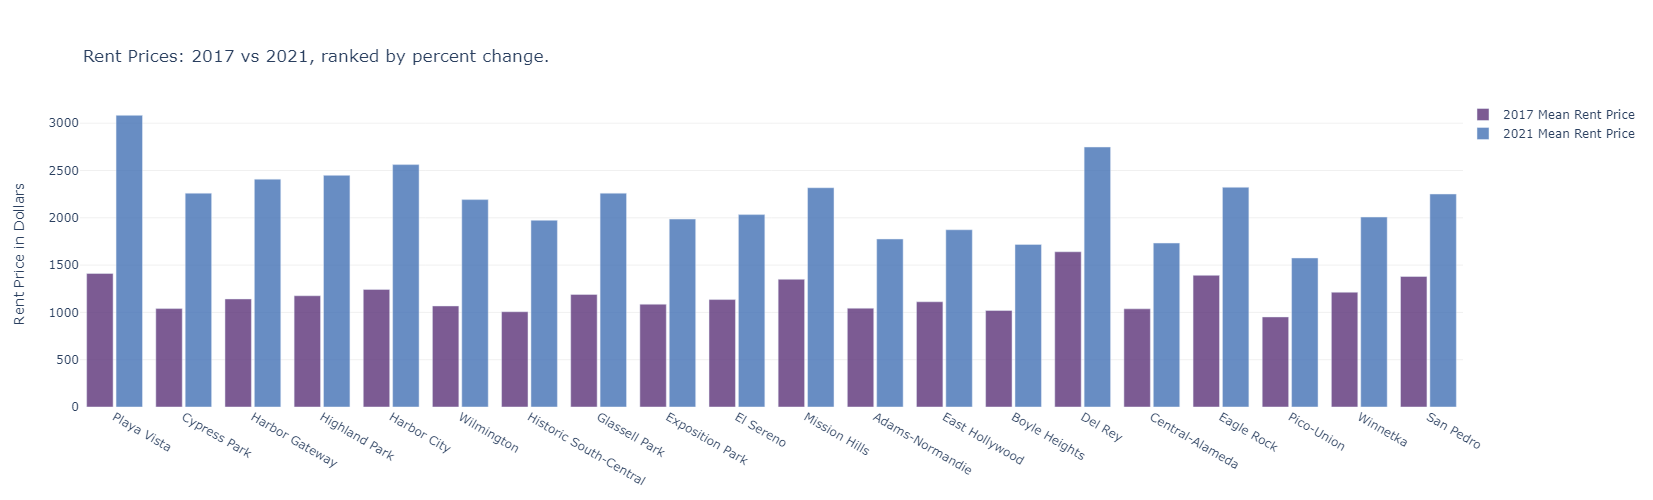

In [41]:
# let's plot our findings from above via a bar graph with neighborhoods on the x-axis, with the left bar indicating 2017 building permit numbers and the right bar indicating 2021 building permit numbers
fig = go.Figure()

fig.add_trace(go.Bar(x=nbh_rent_plot.head(20)['name'],
                y=nbh_rent_plot.head(20)['rent_17_mean'],
                name='2017 Mean Rent Price',
                marker_color='#5c3379',
                     opacity = .8
                ))
fig.add_trace(go.Bar(x=nbh_rent_plot.head(20)['name'],
                y=nbh_rent_plot.head(20)['rent_21_mean'],
                name='2021 Mean Rent Price',
                marker_color='#4371b5',
                     opacity = .8
                ))

fig.update_layout(
    title='Rent Prices: 2017 vs 2021, ranked by percent change.',
    title_y = .9,
    xaxis_tickfont_size=12,
    yaxis=dict(
        title='Rent Price in Dollars',
        titlefont_size=14,
        tickfont_size=12,
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        x=1,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 ,# gap between bars of the same location coordinate.
    
    width=1500,
    height=500
)

fig.update_yaxes(showgrid=True, gridwidth=.5, gridcolor='#e0e0e0')
fig.show()

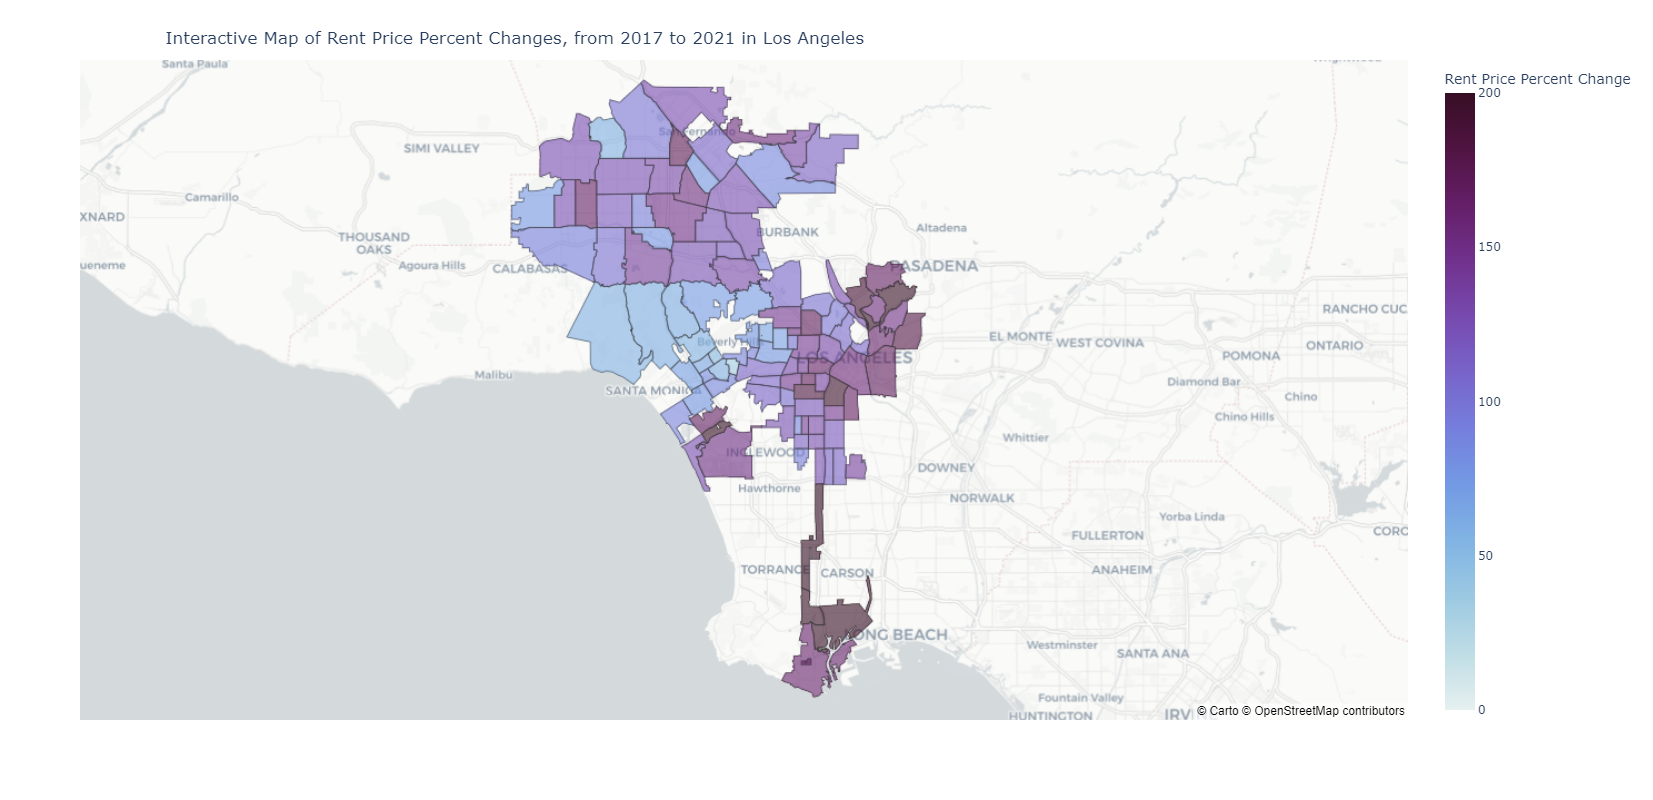

In [42]:
# create chloropleth map that evaluates the differential seen between the two bars above (expanded for whole dataset rather than just black neighborhoods)
chor_map(data = nbh_rent, color = 'Rent Price Percent Change', title = 'Interactive Map of Rent Price Percent Changes, from 2017 to 2021 in Los Angeles', range_color = (0,200))

Remarks:
- Again, although there is not too much to glean from this quite yet as it has not been integrated with our other metrics, we're getting closer to evaluating gentrification across Los Angeles neighborhoods as well as better understanding rent shifts across the city.
- Many neighborhoods in central LA seem to have experienced significant increases in rent price while many of the affluent neighborhoods in west LA seem to have remained largely the same.
________________________________________________________________________________________________________________________________________________________________________________________________________________


#### A3: Demographic Shifts in Renter-occupied Households

Our last step is to bring in race data of renter-occupied households from 2017 and 2021, conducting some pre-cleaning as we bring them into the notebook. Up until this point, we have looked at our gentrification variables in isolation. However, literature and data dictates that the process of gentrification is highly racialized. Our final metric will take this into account by evaluating race through a black vs. white lens, rather than a non-white vs white lens. Although this latter approach is important and necessary to examine, for the purposes of our project, we will only look at white and black renters.

In [43]:
# import demographic csv file data from 2017 Census, rename FIPS column for merge and add a leading zero.
tracts_race_17 = pd.read_csv('data/race_2017.csv', dtype = {'fips':str})
# rename columns to align dataframes
tracts_race_17.rename(columns={'fips': 'FIPS'}, inplace=True)
# we're only looking at black vs white shifts in demographics, so we'll remove other races
tracts_race_17 = tracts_race_17.drop(columns=['american_indian','asian','hawaiian','other','two_or_more','white_not_hispanic','hispanic'])
# add leading 0 to FIPS column
tracts_race_17['FIPS'] = tracts_race_17['FIPS'].str.zfill(11)

# import demographic csv file data from 2021 Census, rename some columns for merge and add a leading zero.
tracts_race_21 = pd.read_csv('data/rent_burden_ct_1.csv',dtype = {'Geo_FIPS':str})
# rename columns for clarity and to align dataframes
tracts_race_21.rename(columns={'Geo_FIPS':'FIPS','total_housing_units': 'total','white_alone':'white','black_alone':'black'}, inplace=True)
# we're only looking at black vs white shifts in demographics, so we'll remove other races
tracts_race_21 = tracts_race_21.drop(columns=['american_indian_alone','asian_alone','native_hawaiian_alone','other','two_or_more','white_alone_not_hisp','hispanic','total_pop','rent_burden'])
# add leading 0 to FIPS column
tracts_race_21['FIPS'] = tracts_race_21['FIPS'].str.zfill(11)

# import LA neighborhoods from ArcGIS
nbh = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

Check our renter dataframes where the unit of analysis is census tracts.

In [44]:
#check 2017 dataframe
tracts_race_17

FIPS  total  white  black
0     06037101110    816    587     26
1     06037101122    230    211      0
2     06037101210   1975   1551     69
3     06037101220    808    532     11
4     06037101300    171    112      0
...           ...    ...    ...    ...
2341  06037980031     32      5     27
2342  06037980033     12      0      0
2343  06037990100      0      0      0
2344  06037990200      0      0      0
2345  06037990300      0      0      0

[2346 rows x 4 columns]

In [45]:
#check 2021 dataframe
tracts_race_21

FIPS  total  white  black
0     06037101110    644    438      0
1     06037101122    344    287      0
2     06037101220    762    450      8
3     06037101221   1140    815     68
4     06037101222    816    715     17
...           ...    ...    ...    ...
2493  06037980038      0      0      0
2494  06037980039      0      0      0
2495  06037990100      0      0      0
2496  06037990200      0      0      0
2497  06037990300      0      0      0

[2498 rows x 4 columns]

Our two dataframes contain census tract identifiers, along with values for each category of race (black and white only) for renter-occupied households. It is also important to note that the Census was conducted in 2020, meaning the census tract boundaries are either different or have completely changed in some cases. We wanted to ensure that we had a good historical coverage to view demographic shifts through but we are doing so at the cost of lost observations due to dissimilar census tracts. There are 2,346 census tracts in the 2017 data while there are 2,498 census tracts in the 2021 data, lets merge the data together on common census tracts and see which how many were retained.

In [46]:
#merge census tract dataframes from both years on FIPS, then review data
race_merge = tracts_race_17.merge(tracts_race_21, on='FIPS',
                                  suffixes=('_2017', '_2021'),
                                 indicator=True)
# examine dataframe
race_merge.describe()

total_2017   white_2017   black_2017   total_2021   white_2021  \
count  2022.000000  2022.000000  2022.000000  2022.000000  2022.000000   
mean    727.787339   371.790307    85.225519   732.410979   327.737389   
std     478.751748   337.873194   143.152049   493.469446   324.412235   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     364.000000   147.000000     0.000000   356.500000   119.000000   
50%     662.000000   275.500000    32.000000   660.500000   230.000000   
75%     991.500000   497.000000   101.750000  1009.000000   421.000000   
max    3879.000000  3217.000000  1587.000000  3895.000000  2868.000000   

        black_2021  
count  2022.000000  
mean     83.417903  
std     139.688290  
min       0.000000  
25%       0.000000  
50%      33.000000  
75%     104.000000  
max    1218.000000

After merging to ensure that all similar census tracts were accounted for, we've reduced our overall count to 2,022 census tracts. We will separate the dataframe by year, add a year column and then append them together in order to create a longer (rather than a wider) dataframe.

In [47]:
# now disaggregatge to make the dataset long instead of wide to prepare for appending
ct_21 = race_merge[['FIPS','total_2021','white_2021','black_2021']]
ct_21.rename(columns={'total_2021': 'total','white_2021':'white','black_2021':
                               'black'}, inplace=True)
ct_17 = race_merge.drop(columns=['_merge','total_2021','white_2021','black_2021'])
ct_17.rename(columns={'total_2017': 'total','white_2017':'white','black_2017':
                               'black','asian_2017':'asian','hispanic_2017':'hispanic' }, inplace=True)

We've separated the dataframes and now will append one dataframe to the end of the other.

In [48]:
# add column for year for each demographic dataset
ct_17['year']=2017
ct_21['year']=2021
# demogaphic information is ready to be appended
ct_race=ct_17.append(ct_21)
# 10 year census tract data for understanding of demograhic shifts, with each shared census tract having two observations (one for 2017 and one for 2021)
ct_race.sort_values('FIPS')

FIPS  total  white  black  year
0     06037101110    816    587     26  2017
0     06037101110    644    438      0  2021
1     06037101122    230    211      0  2017
1     06037101122    344    287      0  2021
2     06037101220    808    532     11  2017
...           ...    ...    ...    ...   ...
2019  06037990100      0      0      0  2017
2020  06037990200      0      0      0  2021
2020  06037990200      0      0      0  2017
2021  06037990300      0      0      0  2017
2021  06037990300      0      0      0  2021

[4044 rows x 5 columns]

Having organized our data appropriately, we will now add in geospatial information so that we can later spatially join the census tracts into the LA neighborhood geodataframe. This will entail bringing in census tract data, adjusting the columns to match our working dataframe and then a merge to join the data together.

In [49]:
# merge now that we have a shared column
spatial_race=tracts.merge(ct_race, on='FIPS')
# double check this worked correctly
spatial_race

CT20                                           geometry         FIPS  \
0     101110  POLYGON ((-118.28491 34.25948, -118.28492 34.2...  06037101110   
1     101110  POLYGON ((-118.28491 34.25948, -118.28492 34.2...  06037101110   
2     101122  POLYGON ((-118.29015 34.27417, -118.29015 34.2...  06037101122   
3     101122  POLYGON ((-118.29015 34.27417, -118.29015 34.2...  06037101122   
4     101220  POLYGON ((-118.28100 34.25592, -118.28198 34.2...  06037101220   
...      ...                                                ...          ...   
4033  980030  POLYGON ((-118.43236 33.91632, -118.43445 33.9...  06037980030   
4034  980031  POLYGON ((-118.26315 33.76749, -118.26339 33.7...  06037980031   
4035  980031  POLYGON ((-118.26315 33.76749, -118.26339 33.7...  06037980031   
4036  980033  POLYGON ((-118.20878 33.78269, -118.21025 33.7...  06037980033   
4037  980033  POLYGON ((-118.20878 33.78269, -118.21025 33.7...  06037980033   

      total  white  black  year  
0       816    587     26  2017  
1       644    438      0  2021  
2       230    211      0  2017  
3       344    287      0  2021  
4       808    532     11  2017  
...     ...    ...    ...   ...  
4033      0      0      0  2021  
4034     32      5     27  2017  
4035     10     10      0  2021  
4036     12      0      0  2017  
4037     13      0      0  2021  

[4038 rows x 7 columns]

In [50]:
# explore neighborhoods
nbh.head()

OBJECTID                    name  \
0         1         Adams-Normandie   
1         2                  Arleta   
2         3       Arlington Heights   
3         4         Atwater Village   
4         5  Baldwin Hills/Crenshaw   

                                            geometry  
0  POLYGON ((-118.30069 34.03731, -118.30388 34.0...  
1  POLYGON ((-118.44255 34.26412, -118.44240 34.2...  
2  POLYGON ((-118.31862 34.05306, -118.31673 34.0...  
3  MULTIPOLYGON (((-118.27886 34.15321, -118.2788...  
4  POLYGON ((-118.36102 34.02532, -118.36026 34.0...

In [51]:
# check coordinate system to ensure they match on join
nbh.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In order to place our census tract data into the neighborhood geometry we need to first ensure that the coordinate systems align. Once done, we will convert our census tract polygons into point data through the centroid function, allowing us to place our census tracts into the neighborhood boundaries.

In [52]:
# prepare demographic data for spatial join with neighborhoods, set 
spatial_race = spatial_race.to_crs(4326)
# adjust census data to point data
spatial_race['geometry']=spatial_race['geometry'].centroid
# drop unnecessary column0
spatial_race = spatial_race.drop(columns=['CT20'])
# check dataframe
spatial_race

geometry         FIPS  total  white  black  year
0     POINT (-118.29300 34.25948)  06037101110    816    587     26  2017
1     POINT (-118.29300 34.25948)  06037101110    644    438      0  2021
2     POINT (-118.29016 34.26773)  06037101122    230    211      0  2017
3     POINT (-118.29016 34.26773)  06037101122    344    287      0  2021
4     POINT (-118.28164 34.25161)  06037101220    808    532     11  2017
...                           ...          ...    ...    ...    ...   ...
4033  POINT (-118.41424 33.90974)  06037980030      0      0      0  2021
4034  POINT (-118.26284 33.73560)  06037980031     32      5     27  2017
4035  POINT (-118.26284 33.73560)  06037980031     10     10      0  2021
4036  POINT (-118.21687 33.74712)  06037980033     12      0      0  2017
4037  POINT (-118.21687 33.74712)  06037980033     13      0      0  2021

[4038 rows x 6 columns]

Now that the race data is cleaned and prepped, we will run a spatial join on the race data (now with census tract centroids) and the neighborhood polygon data.

In [53]:
# spatial join
nbh_race = nbh.sjoin(spatial_race, how="left")
# drop unnecessary columns
nbh_race.sort_values(by=['FIPS','year'])
nbh_race

OBJECTID             name  \
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
0           1  Adams-Normandie   
..        ...              ...   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   
113       114      Lake Balboa   

                                              geometry  index_right  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1225   
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1222   
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1223   
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1241   
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1240   
..                                                 ...          ...   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...          470   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...          457   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...          456   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...          458   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...          459   

            FIPS  total  white  black  year  
0    06037221601    796    222    152  2021  
0    06037221500   1031    161    453  2017  
0    06037221500    850    215    283  2021  
0    06037222100    795    216    196  2021  
0    06037222100    782    111    281  2017  
..           ...    ...    ...    ...   ...  
113  06037131900    342    190     25  2017  
113  06037131100    119     65      0  2021  
113  06037131100    218    124     15  2017  
113  06037131200    372    266     16  2017  
113  06037131200    291    172     10  2021  

[1766 rows x 9 columns]

Now that we've successfully joined the dataframes, let's organize our new geodataframe, create new columns based on the metric we're interested in analyzing and then sort by those new columns.

In [54]:
# collapse by year and neighborhood
nbhr = nbh_race.groupby(['year','name'], as_index=False).agg(geometry = ('geometry','first'),
                                                               total = ('total','sum'),
                                                               white = ('white','sum'),
                                                               black = ('black','sum')
                                                              )
nbhr = nbhr.sort_values(by=['name', 'year'])
nbhr

year               name  \
0    2017    Adams-Normandie   
114  2021    Adams-Normandie   
1    2017             Arleta   
115  2021             Arleta   
2    2017  Arlington Heights   
..    ...                ...   
225  2021     Windsor Square   
112  2017           Winnetka   
226  2021           Winnetka   
113  2017     Woodland Hills   
227  2021     Woodland Hills   

                                              geometry  total  white  black  
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4187    713   1332  
114  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4246   1132    930  
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...    848    487     11  
115  POLYGON ((-118.44255 34.26412, -118.44240 34.2...    723    368      0  
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...   5181   1217    983  
..                                                 ...    ...    ...    ...  
225  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   1863    546    134  
112  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   5304   2033    369  
226  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   5510   1741    300  
113  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   7849   5761    504  
227  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   8642   5528   1280  

[228 rows x 6 columns]

Now that our geodataframe is organized appropriately, we will generate new columns based on white and black demographic shifts. After doing so, considering we no longer have use for our 2017 data, we will drop those rows along with any 2021 rows that have missing data. We will then generate a new column that evaluates the differential between the black and white renter population shift as a way to measure the neighborhoods experiencing the greatest change - we will sort our dataframe by this value and produce a bar chart that visualizes this.

In [55]:
# row calculations to determine % shifts in renter-occupied household demographics
nbhr['delta_b'] = nbhr['black'].div(nbhr.groupby('name')['black'].shift())
nbhr['delta_b_perc'] = nbhr['delta_b']*100
nbhr['delta_w'] = nbhr['white'].div(nbhr.groupby('name')['white'].shift())
nbhr['delta_w_perc'] = nbhr['delta_w']*100
# add column which accounts for the % change in demographic shift between white and black renters 
nbhr['Percent Differential'] = nbhr.delta_w_perc - nbhr.delta_b_perc
#check column
nbhr

year               name  \
0    2017    Adams-Normandie   
114  2021    Adams-Normandie   
1    2017             Arleta   
115  2021             Arleta   
2    2017  Arlington Heights   
..    ...                ...   
225  2021     Windsor Square   
112  2017           Winnetka   
226  2021           Winnetka   
113  2017     Woodland Hills   
227  2021     Woodland Hills   

                                              geometry  total  white  black  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4187    713   1332   
114  POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4246   1132    930   
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...    848    487     11   
115  POLYGON ((-118.44255 34.26412, -118.44240 34.2...    723    368      0   
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...   5181   1217    983   
..                                                 ...    ...    ...    ...   
225  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   1863    546    134   
112  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   5304   2033    369   
226  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   5510   1741    300   
113  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   7849   5761    504   
227  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   8642   5528   1280   

      delta_b  delta_b_perc   delta_w  delta_w_perc  Percent Differential  
0         NaN           NaN       NaN           NaN                   NaN  
114  0.698198     69.819820  1.587658    158.765778             88.945959  
1         NaN           NaN       NaN           NaN                   NaN  
115  0.000000      0.000000  0.755647     75.564682             75.564682  
2         NaN           NaN       NaN           NaN                   NaN  
..        ...           ...       ...           ...                   ...  
225  0.644231     64.423077  1.056093    105.609284             41.186207  
112       NaN           NaN       NaN           NaN                   NaN  
226  0.813008     81.300813  0.856370     85.636990              4.336177  
113       NaN           NaN       NaN           NaN                   NaN  
227  2.539683    253.968254  0.959556     95.955563           -158.012691  

[228 rows x 11 columns]

In [56]:
# drop 2017 values as we've already captured the difference between the two years via the 'difference' column.
# this step is separate as we need to utilize this dataframe for other measures
nbhr_2021 = nbhr[nbhr.year == 2021].reset_index(drop = True)
nbhr_2021

year                    name  \
0    2021         Adams-Normandie   
1    2021                  Arleta   
2    2021       Arlington Heights   
3    2021         Atwater Village   
4    2021  Baldwin Hills/Crenshaw   
..    ...                     ...   
109  2021                Westwood   
110  2021              Wilmington   
111  2021          Windsor Square   
112  2021                Winnetka   
113  2021          Woodland Hills   

                                              geometry  total  white  black  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4246   1132    930   
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...    723    368      0   
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...   5179   1232   1203   
3    MULTIPOLYGON (((-118.27886 34.15321, -118.2788...   2803   1466      8   
4    POLYGON ((-118.36102 34.02532, -118.36026 34.0...   4388    530   2908   
..                                                 ...    ...    ...    ...   
109  POLYGON ((-118.42946 34.07925, -118.42938 34.0...   4429   2751    158   
110  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...   9508   5702    530   
111  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   1863    546    134   
112  POLYGON ((-118.56232 34.23199, -118.56232 34.2...   5510   1741    300   
113  POLYGON ((-118.57240 34.18668, -118.57161 34.1...   8642   5528   1280   

      delta_b  delta_b_perc   delta_w  delta_w_perc  Percent Differential  
0    0.698198     69.819820  1.587658    158.765778             88.945959  
1    0.000000      0.000000  0.755647     75.564682             75.564682  
2    1.223805    122.380468  1.012325    101.232539            -21.147929  
3    0.444444     44.444444  1.000000    100.000000             55.555556  
4    0.910457     91.045711  0.746479     74.647887            -16.397823  
..        ...           ...       ...           ...                   ...  
109  0.969325     96.932515  0.880602     88.060179             -8.872336  
110  1.373057    137.305699  1.264582    126.458195            -10.847505  
111  0.644231     64.423077  1.056093    105.609284             41.186207  
112  0.813008     81.300813  0.856370     85.636990              4.336177  
113  2.539683    253.968254  0.959556     95.955563           -158.012691  

[114 rows x 11 columns]

Before visualizing our data, we want to isolate neighborhoods that satisfy a few key crieria. First, we want to ensure that the size of the black renter population is signficiant enough for analysis. Second we want to make sure that the percentage of black renters decreased over time. Lastly, we want to make sure that the white renter population increased. This will ultimately help us understand what neighborhoods demonstrated black displacement by white renters.

In [57]:
# select for the black communities that are populous and where black folks have moved or been moved out in the past decade
nbhr_trim_black = nbhr_2021[((nbhr_2021['black']/nbhr_2021['total'])>.08) & (nbhr_2021['delta_b_perc']<100) & (nbhr_2021['delta_w_perc']>100)]
# sort by the difference between black emigration and white immigration
nbhr_trim_black = nbhr_trim_black.sort_values('Percent Differential', ascending = False)
nbhr_trim_black

year                 name  \
0    2021      Adams-Normandie   
51   2021       Jefferson Park   
31   2021      Exposition Park   
107  2021          Westchester   
11   2021  Broadway-Manchester   
100  2021       Vermont Square   
101  2021        Vermont Vista   
86   2021           South Park   
37   2021        Green Meadows   
41   2021          Harbor City   
80   2021            San Pedro   

                                              geometry  total  white  black  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4246   1132    930   
51   POLYGON ((-118.31335 34.03721, -118.30900 34.0...   6268   1416   2517   
31   POLYGON ((-118.29155 34.01837, -118.28294 34.0...   6115   1419   1753   
107  POLYGON ((-118.35862 33.98240, -118.35856 33.9...   3906   1953    588   
11   POLYGON ((-118.26954 33.92919, -118.26956 33.9...   4211    975   1555   
100  POLYGON ((-118.28112 34.01109, -118.28121 34.0...   5710   1769   1624   
101  POLYGON ((-118.28044 33.92912, -118.28066 33.9...   3606    915   1456   
86   POLYGON ((-118.28040 33.98916, -118.28061 33.9...   5655   1648    807   
37   POLYGON ((-118.25411 33.95104, -118.25411 33.9...   4960   1277   1794   
41   POLYGON ((-118.29902 33.80355, -118.29903 33.8...   4492   1681    636   
80   MULTIPOLYGON (((-118.28845 33.75438, -118.2885...  14792   8103   1458   

      delta_b  delta_b_perc   delta_w  delta_w_perc  Percent Differential  
0    0.698198     69.819820  1.587658    158.765778             88.945959  
51   0.856122     85.612245  1.573333    157.333333             71.721088  
31   0.880020     88.002008  1.376334    137.633366             49.631358  
107  0.733167     73.316708  1.153574    115.357354             42.040646  
11   0.730047     73.004695  1.090604    109.060403             36.055708  
100  0.874529     87.452881  1.227620    122.761971             35.309090  
101  0.917454     91.745432  1.194517    119.451697             27.706265  
86   0.771511     77.151052  1.036478    103.647799             26.496747  
37   0.887679     88.767937  1.108507    110.850694             22.082758  
41   0.992200     99.219969  1.172245    117.224547             18.004578  
80   0.875676     87.567568  1.049340    104.933955             17.366387

We will leverage this data frame to produce a bar graph later on adjacent to our first map. For now, we will clean up our larger neighborhood dataframe to include on our map.

Evaluate non-sensical data as this will distort the manner in which we place our neighborhoods into quantiles.

In [58]:
# examine extreme values and null values
print(nbhr_2021.delta_b_perc.min())
print(nbhr_2021.delta_b_perc.max())
print(nbhr_2021.delta_w_perc.min())
print(nbhr_2021.delta_w_perc.max())
print(nbhr_2021.delta_b_perc.isnull().sum())
print(nbhr_2021.delta_w_perc.isnull().sum())

0.0
inf
32.7319587628866
158.76577840112202
8
3


In [59]:
# remove infinite and 0 values
nbhr_clean = nbhr_2021[(nbhr_2021.delta_b_perc != np.inf) & (nbhr_2021.delta_b_perc != 0)]
# remove NaN values
nbhr_clean = nbhr_clean.dropna()
# check if successful
nbhr_clean.shape

(102, 11)

We will use a for loop and if statements to assign each row (neighborhood) a quantile (demarcated by a letter). This will be done for both the white and black shift in renter populations.

In [60]:
# black renter shift
# create empty object to store values
black_rank = []
# iterate through each row and classify each neighbhorhood by the quantile of their score.
for value in nbhr_clean['delta_b_perc']:
    if value <= np.percentile(nbhr_clean['delta_b_perc'], 25):
        black_rank.append("A")
    elif value <= np.percentile(nbhr_clean['delta_b_perc'], 50):
        black_rank.append("B")
    elif value <= np.percentile(nbhr_clean['delta_b_perc'], 75):
        black_rank.append("C")
    else:
        black_rank.append("D")

# assign new column to dataframe which captures their rank
nbhr_clean['black_rank'] = black_rank


# white renter shift
# create empty object to store values 
white_rank = []
# iterate through each row and classify each neighbhorhood by the quantile of their score.
for value in nbhr_clean['delta_w_perc']:
    if value <= np.percentile(nbhr_clean['delta_w_perc'], 25):
        white_rank.append("D")
    elif value <= np.percentile(nbhr_clean['delta_w_perc'], 50):
        white_rank.append("C")
    elif value <= np.percentile(nbhr_clean['delta_w_perc'], 75):
        white_rank.append("B")
    else:
        white_rank.append("A")

# assign new column to dataframe which captures their rank    
nbhr_clean['white_rank'] = white_rank

# combine rankings
nbhr_clean['combined_rank'] = nbhr_clean['black_rank'] + nbhr_clean['white_rank']
# set geometry to visualize later
nbhr_clean = nbhr_clean.set_geometry('geometry')
# view dataframe
pd.set_option('display.max_rows',150)
nbhr_clean.sort_values('combined_rank')

year                    name  \
0    2021         Adams-Normandie   
65   2021        Mount Washington   
55   2021               Larchmont   
54   2021       Lake View Terrace   
20   2021               Chinatown   
107  2021             Westchester   
11   2021     Broadway-Manchester   
49   2021    Hollywood Hills West   
111  2021          Windsor Square   
36   2021           Granada Hills   
81   2021                Sawtelle   
48   2021         Hollywood Hills   
93   2021                 Tujunga   
3    2021         Atwater Village   
85   2021             Silver Lake   
104  2021              West Adams   
30   2021                  Encino   
64   2021       Montecito Heights   
87   2021             Studio City   
19   2021           Cheviot Hills   
18   2021     Chesterfield Square   
63   2021           Mission Hills   
56   2021            Leimert Park   
14   2021         Central-Alameda   
79   2021                  Reseda   
70   2021                 Pacoima   
86   2021              South Park   
51   2021          Jefferson Park   
80   2021               San Pedro   
37   2021           Green Meadows   
100  2021          Vermont Square   
101  2021           Vermont Vista   
31   2021         Exposition Park   
60   2021               Mar Vista   
71   2021                   Palms   
43   2021         Harvard Heights   
58   2021               Los Feliz   
73   2021          Pico-Robertson   
91   2021                 Tarzana   
112  2021                Winnetka   
61   2021                Mid-City   
68   2021              Northridge   
33   2021                Florence   
109  2021                Westwood   
44   2021            Harvard Park   
72   2021           Panorama City   
4    2021  Baldwin Hills/Crenshaw   
27   2021               El Sereno   
90   2021                  Sylmar   
46   2021  Historic South-Central   
66   2021             North Hills   
41   2021             Harbor City   
94   2021         University Park   
2    2021       Arlington Heights   
106  2021        West Los Angeles   
74   2021              Pico-Union   
84   2021            Sherman Oaks   
53   2021             Lake Balboa   
92   2021             Toluca Lake   
62   2021            Mid-Wilshire   
98   2021                  Venice   
10   2021               Brentwood   
52   2021               Koreatown   
25   2021          East Hollywood   
97   2021                Van Nuys   
95   2021             Valley Glen   
45   2021           Highland Park   
67   2021         North Hollywood   
35   2021           Gramercy Park   
102  2021         Vermont-Slauson   
88   2021              Sun Valley   
9    2021           Boyle Heights   
103  2021                   Watts   
42   2021          Harbor Gateway   
99   2021          Vermont Knolls   
50   2021               Hyde Park   
75   2021             Playa Vista   
105  2021              West Hills   
39   2021            Hancock Park   
110  2021              Wilmington   
108  2021                Westlake   
113  2021          Woodland Hills   
77   2021            Porter Ranch   
76   2021           Playa del Rey   
7    2021           Beverly Grove   
47   2021               Hollywood   
24   2021              Eagle Rock   
23   2021                Downtown   
22   2021                 Del Rey   
78   2021             Rancho Park   
96   2021          Valley Village   
32   2021                 Fairfax   
29   2021          Elysian Valley   
83   2021            Shadow Hills   
13   2021                 Carthay   
15   2021            Century City   
12   2021             Canoga Park   
26   2021               Echo Park   
34   2021           Glassell Park   
57   2021         Lincoln Heights   
16   2021              Chatsworth   
59   2021       Manchester Square   

                                              geometry  total  white  black  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...   4246   1132    930   
65   POLYGON ((-118.21356 34.11627,

Now that we have a combined ranking for each neighborhood, we need to develop a bivariate color map in order to appropriately visualize their combined values. We will first need to create a custom bivariate color map to demonstrate the differences in race shifts.

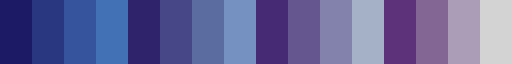

In [61]:
# set to create a complete legend
import matplotlib
colors = ["#d3d3d3", "#aa9cb4", "#826796", "#5c3379", "#a3b2c9", "#8383ac", "#64578f", "#472b73", "#7492bf", "#5d6ba3", "#474788", "#32236e", "#4371b5", "#36539b", "#293781", "#1d1b68"]
colors_cmap = colors[::-1]
cmap = matplotlib.colors.ListedColormap(colors_cmap)
cmap

Now that we have a working cmap, we want to be able to tie our bar graph to our choropleth map visually. We'll do this by grabbing the centroid of each neighborhood and assigning a number to the neighborhood name based on its ranking of the *percent differential* value.

In [62]:
# set geometry to the polygon data, create a new centroid column then set that as the new geometry
nbhr_trim_black = nbhr_trim_black.set_geometry('geometry')
nbhr_trim_black['centroid'] = nbhr_trim_black.geometry.centroid
nbhr_trim_black = nbhr_trim_black.set_geometry('centroid')

In [63]:
# extract the lat and long for each neighborhood so that we can iterate on it later to place our numbers on the plot
nbhr_trim_black['centroid_str'] = nbhr_trim_black['centroid'].astype('str')
nbhr_trim_black['centroid_str'] = nbhr_trim_black['centroid_str'].str.strip('POINT ').str.replace('(','').str.replace(')','')
nbhr_trim_black[['LONG', 'LAT']] = nbhr_trim_black['centroid_str'].str.split(' ', 1, expand=True).astype('float')
nbhr_trim_black = nbhr_trim_black.reset_index()
nbhr_trim_black['name'] = (nbhr_trim_black.index + 1).astype('str') + '. ' + nbhr_trim_black['name']

We are all ready to plot!

Text(20, 11.0, 'Neighborhoods > 8% Black, ranked by Percent Differentials')

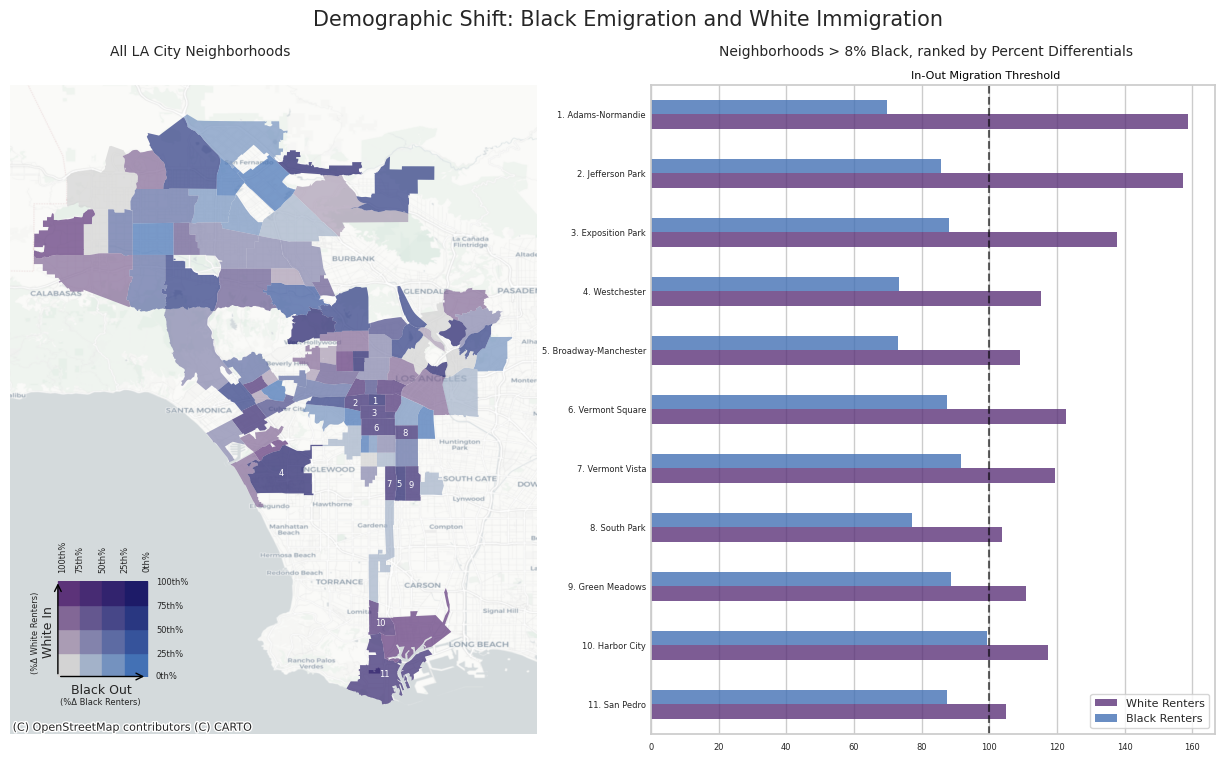

In [64]:
# set plot style
sns.set(style="whitegrid")

# create figure, axes
fig, ax = plt.subplots(1,2,figsize=(14,8))

# plot map
nbhr_clean.plot(ax=ax[0], 
          column='combined_rank', 
          cmap=cmap, 
          categorical=True, 
          legend=False,
          alpha = .7,
          linewidth=0) 

# add context basemap
ctx.add_basemap(ax=ax[0], crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

# "tighten" two figures map and basemap
plt.tight_layout(pad=3.5)

# turn off axis
ax[0].axis('off')


# create custom bivariate legend
ax2 = fig.add_axes([0.12, 0.18, 0.07, 0.12])

#alpha control
alpha = 1

# Column 1
ax2.axvspan(xmin=0, xmax=0.25, ymin=0, ymax=0.25, alpha=alpha, color=colors[0])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.25, ymax=0.50, alpha=alpha, color=colors[1])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.50, ymax=0.75, alpha=alpha, color=colors[2])
ax2.axvspan(xmin=0, xmax=0.25, ymin=0.75, ymax=1, alpha=alpha, color=colors[3])

# Column 2
ax2.axvspan(xmin=0.25, xmax=0.50, ymin=0, ymax=0.25, alpha=alpha, color=colors[4])
ax2.axvspan(xmin=0.25, xmax=0.50, ymin=0.25, ymax=0.50, alpha=alpha, color=colors[5])
ax2.axvspan(xmin=0.25, xmax=0.50, ymin=0.50, ymax=0.75, alpha=alpha, color=colors[6])
ax2.axvspan(xmin=0.25, xmax=0.50, ymin=0.75, ymax=1, alpha=alpha, color=colors[7])

# Column 3
ax2.axvspan(xmin=0.50, xmax=.75, ymin=0, ymax=0.25, alpha=alpha, color=colors[8])
ax2.axvspan(xmin=0.50, xmax=.75, ymin=0.25, ymax=0.50, alpha=alpha, color=colors[9])
ax2.axvspan(xmin=0.50, xmax=.75, ymin=0.50, ymax=0.75, alpha=alpha, color=colors[10])
ax2.axvspan(xmin=0.50, xmax=.75, ymin=0.75, ymax=1, alpha=alpha, color=colors[11])

# Column 4
ax2.axvspan(xmin=0.75, xmax=1, ymin=0, ymax=0.25, alpha=alpha, color=colors[12])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.25, ymax=0.50, alpha=alpha, color=colors[13])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.50, ymax=0.75, alpha=alpha, color=colors[14])
ax2.axvspan(xmin=0.75, xmax=1, ymin=0.75, ymax=1, alpha=alpha, color=colors[15])

# legend annotations
ax2.axis('off'); # turn off its axis
ax2.text(s='(%Δ Black Renters)', x=0.02, y=-0.3, fontsize = 6) # annotate x axis
ax2.text(s='Black Out', x=0.15, y=-0.18, fontsize = 9) # annotate x axis
ax2.text(s='(%Δ White Renters)', x=-0.3, y=0.05, fontsize = 6, rotation=90); # annotate y axis
ax2.text(s='White In', x=-0.18, y=0.23, fontsize = 9, rotation=90); # annotate y axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1, color = 'black')) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1, color = 'black')) # draw arrow for y 

ax2.text(s='100th%', x=1.1, y=.95, fontsize = 6) # annotate x axis
ax2.text(s='75th%', x=1.1, y=.7, fontsize = 6) # annotate y axis
ax2.text(s='50th%', x=1.1, y=.45, fontsize = 6) # annotate y axis
ax2.text(s='25th%', x=1.1, y=.21, fontsize = 6) # annotate y axis
ax2.text(s='0th%', x=1.1, y=-.02, fontsize = 6) # annotate y axis

ax2.text(s='0th%', x=.95, y=1.11, fontsize = 6, rotation= 90) # annotate x axis
ax2.text(s='25th%', x=0.7, y=1.1, fontsize = 6, rotation= 90) # annotate y axis
ax2.text(s='50th%', x=0.45, y=1.1, fontsize = 6, rotation= 90) # annotate y axis
ax2.text(s='75th%', x=0.2, y=1.1, fontsize = 6, rotation= 90) # annotate y axis
ax2.text(s='100th%', x=0.0, y=1.1, fontsize = 6, rotation= 90) # annotate y axis


# label map based on bar graph
for index in range(len(nbhr_trim_black)):
    ax[0].text(s=index+1, x=nbhr_trim_black['LONG'][index]-.005, y=nbhr_trim_black['LAT'][index]-.004, size = 6, color = "white")
    
# plot secondary bar graph
nbhr_trim_black.sort_values('Percent Differential', ascending = True).plot.barh(ax = ax[1], x = "name", y = ["delta_w_perc","delta_b_perc"], color=['#5c3379', '#4371b5'], linewidth=0, alpha = .8)

# adjust graph settings
ax[1].tick_params(axis="x",labelsize = 6, pad=.5)
ax[1].tick_params(axis="y",labelsize = 6, pad = -2.5)
ax[1].yaxis.label.set_visible(False)
ax[1].grid(axis = "y", alpha=.0)

# create legend
ax[1].legend(labels=['White Renters','Black Renters'], fontsize =8)

# add annotations
ax[1].axvline(x = 100, color = 'black', linestyle="--", alpha = .6)
ax[1].text(s="In-Out Migration Threshold", x=77, y=10.6, size = 8, color = "black")

# add titles/subtitles
ax[1].text(s="Demographic Shift: Black Emigration and White Immigration", x = -100, y = 11.5, size = 15)
ax[1].text(s="All LA City Neighborhoods", x = -160, y = 11., size = 10)
ax[1].text(s="Neighborhoods > 8% Black, ranked by Percent Differentials", x = 20, y = 11., size = 10)

In [ ]:
nbhr_clean.to_csv('final_dfs/race.csv')
nbh_rent.to_csv('final_dfs/rent.csv')
neighborhoods_permits_combined.to_csv('final_dfs/permits.csv')